## Nbdev import session

In [1]:
#default_exp kernel

In [1]:
#hide
from nbdev.showdoc import *

#%load_ext autoreload
#%autoreload 2

import sys
sys.path.insert(0, '..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root


# Code

In [2]:
#export
from functools import reduce

from typing import Union

from scipy import sparse
import numpy as np

from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline

from sknetwork.clustering import KMeans, Louvain, PropagationClustering

from nmslearn.neighbors import FastJaccardNN, FastKLDivNN, FastL2NN

from heartwood.utils import hstack, RobustEncoder, sparse_dot_product

In [3]:
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor

In [4]:
#session of variables to testing sessions
n_features = 7
cardinality_per_feature = 1000
n_classes = 5
n_reg_dims = 2


X = np.random.randint(0,cardinality_per_feature,(1000,n_features))

y_class = np.random.randint(0,n_classes, 1000)
y_reg = np.random.randn(1000,n_reg_dims)

In [5]:
#export
from sklearn.datasets import make_regression

def sigmoid(x):
    return 1/(1+np.exp(x))

def make_bimodal_assymetric_regression(
    n_samples=100000,
    bimodal_factor_weight = 2,
    n_features=15,
    n_informative=6,
    n_targets=2,
    bias=500,
    effective_rank=None,
    tail_strength=10,
    noise=150,
    shuffle=True,
    coef=False,
    random_state=None
):
    
    X,y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_targets=n_targets,
        bias=bias,
        effective_rank=effective_rank,
        tail_strength=tail_strength,
        noise=noise,
        shuffle=shuffle,
        coef=coef,
        random_state=random_state
    )


    #make one of X[1] feature mode weightening    
    bimodal_factors = (sigmoid(bimodal_factor_weight*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int)
    bimodal_factors[bimodal_factors == 0] = -1
    bimodal_factors = bimodal_factors.reshape(-1,1)

    y = bimodal_factors*y
    
    return X,y

In [273]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression, make_blobs
import seaborn as sns

%matplotlib inline

X, y = make_classification(
    n_samples = 100_000,
    n_features = 3,
    n_informative = 3,
    n_redundant = 0,
    #bias = 10,
    #noise = 10,
    n_classes = 3,
    n_clusters_per_class = 2,
    hypercube = True,
)


blobs, labels = make_blobs(n_samples = 10_000,cluster_std = 3, n_features = 4)
#sns.scatterplot(*blobs.T, hue = labels)
#plt.show()

In [274]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

import plotly.io as pio
pio.renderers.default='iframe'

df = pd.DataFrame(X)
df.columns = [f'X{i}' for i in range(X.shape[-1])]
df['y'] = y.astype(str)

fig = px.scatter_3d(df, x='X0', y='X1', z='X2',
              color='y')
#fig.show()

#plt.cls()
#sns.scatterplot(*X.T[:2], hue = y)
#plt.show()

In [275]:
#export
def sparsify(*arrs):
    '''
    makes input arrs sparse
    '''
    arrs = list(arrs)
    for i in range(len(arrs)):        
        if not sparse.issparse(arrs[i]):
            arrs[i] = sparse.csr_matrix(arrs[i])
    
    return arrs

def _robust_stack(blocks, stack_method = 'stack', **kwargs):
    
    if any(sparse.issparse(i) for i in blocks):
        stacked = getattr(sparse, stack_method)(blocks, **kwargs)
    else:
        stacked = getattr(np, stack_method)(blocks, **kwargs)
    return stacked

def hstack(blocks, **kwargs):
    return _robust_stack(blocks, stack_method = 'hstack', **kwargs)

def vstack(blocks, **kwargs):
    return _robust_stack(blocks, stack_method = 'vstack', **kwargs)

def stack(blocks, **kwargs):
    return _robust_stack(blocks, stack_method = 'stack', **kwargs)


class RobustEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self,):            
        '''
        A robust one hot encoder. Always return the same amount of nonzero value sin each transformed row.
        Has columns for unknown values
        '''
        return
    
    def fit(self, X, y = None, **kwawrgs):        
        self.ordinalencoder_ = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1).fit(X)
        
        X = self.ordinalencoder_.transform(X)
        
        categories = [np.arange(-1, len(cats)) for cats in self.ordinalencoder_.categories_]
        self.onehotencoder_ = OneHotEncoder(categories = categories).fit(X)        
        return self
    
    def transform(self, X, **kwargs):
        X = self.ordinalencoder_.transform(X)
        return self.onehotencoder_.transform(X)

In [276]:
#export

class PrefitEstimator(BaseEstimator):
    
    def __init__(self, prefit_estimator):
        self.prefit_estimator = prefit_estimator
        self.is_fitted_ = True
        return
    
    def __getattr__(self, attr):
        '''
        gets the attributes from prefit_estimator, except if the attribute (or method)
        is "fit".
        
        if the "transform" or "predict" method is called, it'll return self.prefit_estimator's method
        '''
        if attr == 'fit':
            return self.fit        
        elif attr == 'fit_transform':
            return self.fit_transform
        elif attr == 'fit_predict':
            return self.fit_predict            
        else:
            return getattr(self.prefit_estimator, attr)
    
    def fit(self, X, y = None, **kwargs):
        '''
        the fit method does nothing (since prefit_estimator is already fitted) and returns self.
        '''
        return self    
    
    def fit_transform(self, X, y = None, **kwargs):
        return self.transform(X) #will get "transform" method from self.prefit_estimator
    
    def fit_predict(self, X, y = None, **kwargs):
        return self.predict(X) #will get "predict" method from self.prefit_estimator

# ForestNeighbors

In [ ]:
class CustomTreePipeline():
    '''
    Extends sklearn Pipeline with tree methods such as `apply` and `decistion_path`
    '''
    pass

class CustomRandomForest():
    '''
    extends RandomForests to work with CustomTreePipeline
    '''
    pass


In [ ]:
class ForestNeighbors(BaseEstimator):
    
    def __init__(
        self,
        forest_estimator,
        n_neighbors = 30,
        radius = .5,
        n_jobs = -1,
        prefit_forest_estimator = False,
    ):
        '''
        Kneighbors search based on terminal node co-ocurrence.
        Trees can be grown adaptatively (supervised tree ensemble) or randomly (unsupervised tree ensemble)        
        '''
        self.forest_estimator = forest_estimator
        self.n_neighbors = n_neighbors
        self.radius = radius
        self.n_jobs = n_jobs
        self.prefit_forest_estimator = prefit_forest_estimator
        return
    
    def fit(self, X, y = None, **kwargs):
        '''
        fits forest_estimator if prefir_forest_estimator is set to False. Then, fits neighbors search index
        '''
        
        if not self.prefit_forest_estimator:
            self.forest_estimator.fit(X = X, y = y, **kwargs)
        else:
            pass
                        
        #get terminal node indexes
        node_indexes = self.forest_estimator.apply(X)        
        #create node encoding pipeline
        index_encoder = make_pipeline(OrdinalEncoder(), OneHotEncoder())
        index_encoder.fit(node_indexes)
        #create node->point mapper
        node_point_mapper = self._create_node_point_mapper(node_indexes, index_encoder)
        point_node_mapping = index_encoder.fit_transform(node_indexes)
        #save states        
        self.point_node_mapping_ = point_node_mapping
        self.index_encoder_ = index_encoder
        return self
    
    def kneighbors(self, X=None, n_neighbors=None, return_distance=True):
        
        if X is None:
            points = self.point_node_mapping_
        
        else:
            
            
    
    def _create_node_point_mapper(self, node_indexes, index_encoder):
        '''
        creates terminal_node->points mapper in order to retrieve points based on terminal nodes
        '''
        point_node_mapping = index_encoder.transform(node_indexes)
        M = point_node_mapping.T.tocsr()
        mapper = np.array(np.split(M.indices, M.indptr)[1:-1])
        return mapper

    def _correct_node_indexes(self, node_indexes, index_encoder):    
        '''
        correct node indexes to reflect actual positional indexing of nodes in the forest
        '''

        node_indexes = index_encoder[0].transform(node_indexes)    
        sum_indexes = np.roll((node_indexes.max(0) + 1).reshape(1,-1).cumsum(), 1, )
        sum_indexes[0] = 0
        sum_indexes = sum_indexes.astype(int)    
        corrected_indexes = (node_indexes + sum_indexes).astype(int)
        return corrected_indexes

    def _postprocess_node_points(self, points, n_neighbors = 30, ):
        '''
        postprocess queried points
        '''    
        dist = []
        idx = []
        n_terminal_nodes = points.shape[1]
        #points = mapper[corrected_indexes]
        for i in range(len(points)):
            idx_, count_ = np.unique(np.concatenate(points[i]), return_counts = True)
            argsort = np.argsort(count_)[::-1][:n_neighbors]
            dist.append(count_[argsort].reshape(1,-1)/n_terminal_nodes)
            idx.append(idx_[argsort].reshape(1,-1))

        dist, idx = np.vstack(dist), np.vstack(idx)
        return dist, idx

In [285]:
encoder = make_pipeline(OrdinalEncoder(), OneHotEncoder())
point_node_mapping = encoder.fit_transform(mxfc.estimators[1].apply(X))
node_indexes = encoder[0].transform(mxfc.estimators[1].apply(X))

In [286]:
M = point_node_mapping.T.tocsr()

mapper = np.array(np.split(M.indices, M.indptr)[1:-1])
len(mapper)

c:\users\user ambev\desktop\mypackages\heartwood\venv\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



238409

In [313]:


%timeit np.bincount(np.concatenate(mapper[[1,2,310]]))#.ravel()
%timeit np.unique(np.concatenate(mapper[[1,2,310]]), return_counts = True)#.ravel()

79.4 µs ± 516 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
24.7 µs ± 879 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [317]:
from joblib import Parallel, delayed

In [316]:
from tqdm import tqdm
n_neighbors = 100


sum_indexes = np.roll((node_indexes.max(0) + 1).reshape(1,-1).cumsum(), 1, )
sum_indexes[0] = 0
sum_indexes = sum_indexes.astype(int)

node_indexes = encoder[0].transform(mxfc.estimators[1].apply(X))
query_node_indexes = node_indexes
corrected_indexes = (query_node_indexes + sum_indexes).astype(int)

n_terminal_nodes = corrected_indexes.shape[1]


dist = []
idx = []
points = mapper[corrected_indexes]
for i in tqdm(range(len(corrected_indexes))):    
    idx_, count_ = np.unique(np.concatenate(points[i]), return_counts = True)
    argsort = np.argsort(count_)[::-1][:n_neighbors]
    dist.append(count_[argsort]/n_terminal_nodes)
    idx.append(idx_[argsort])
    

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:25<00:00, 1166.81it/s]


In [454]:
#fit and save node_ordinal_encoder
def create_node_point_mapper(node_indexes, index_encoder):
    '''
    creates terminal_node->points mapper in order to retrieve points based on terminal nodes
    '''
    point_node_mapping = index_encoder.transform(node_indexes)
    M = point_node_mapping.T.tocsr()
    mapper = np.array(np.split(M.indices, M.indptr)[1:-1])
    return mapper

def correct_node_indexes(node_indexes, index_encoder):    
    '''
    correct node indexes to reflect actual positional indexing of nodes in the forest
    '''
    
    node_indexes = index_encoder[0].transform(node_indexes)    
    sum_indexes = np.roll((node_indexes.max(0) + 1).reshape(1,-1).cumsum(), 1, )
    sum_indexes[0] = 0
    sum_indexes = sum_indexes.astype(int)    
    corrected_indexes = (node_indexes + sum_indexes).astype(int)
    return corrected_indexes

def postprocess_node_points(points, n_neighbors = 30, ):
    '''
    postprocess queried points
    '''    
    dist = []
    idx = []
    n_terminal_nodes = points.shape[1]
    #points = mapper[corrected_indexes]
    for i in range(len(points)):
        idx_, count_ = np.unique(np.concatenate(points[i]), return_counts = True)
        argsort = np.argsort(count_)[::-1][:n_neighbors]
        dist.append(count_[argsort].reshape(1,-1)/n_terminal_nodes)
        idx.append(idx_[argsort].reshape(1,-1))
    
    dist, idx = np.vstack(dist), np.vstack(idx)
    return dist, idx

In [455]:
indexes = mxfc.estimators[1].apply(X)
#correct_node_indexes(indexes, encoder)
encoder.fit(indexes)
mapper = create_node_point_mapper(indexes, encoder)

c:\users\user ambev\desktop\mypackages\heartwood\venv\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [456]:
corrected_indexes = correct_node_indexes(indexes, encoder)
#dist,idx = query_points(mapper, corrected_indexes, n_neighbors = 30, )
#encoder

In [457]:
n_jobs = -1

In [458]:
import time
from joblib import effective_n_jobs

n_jobs = effective_n_jobs(n_jobs)

tic = time.time()
results = Parallel(n_jobs=-1)(delayed(postprocess_node_points)(mapper[i], n_neighbors = 100) for i in np.split(corrected_indexes, n_jobs))
toc = time.time()
print('\nElapsed time Parallel computing {:.2f} s\n'
      .format(toc - tic))


tic = time.time()
results = postprocess_node_points(mapper[corrected_indexes], n_neighbors = 100)
toc = time.time()
print('\nElapsed time single threaded {:.2f} s\n'
      .format(toc - tic))


Elapsed time Parallel computing 34.97 s


Elapsed time single threaded 83.25 s



In [452]:
results[1]

array([[    0,  8411, 42888, ..., 36754, 41879, 51525],
       [    1, 79376, 82944, ..., 25049, 95935, 68841],
       [    2, 77515, 90397, ..., 22734, 90585, 61919],
       ...,
       [99997, 61165, 36725, ...,  7316, 61545, 73973],
       [99998, 71733, 73635, ..., 19548, 18806, 52823],
       [99999, 38335, 58754, ..., 30466, 67099, 74343]], dtype=int32)

# Forest space partitioning

In [277]:
#export

class ForestBipartiteGraphTransformer(BaseEstimator):
    #fit models and graph embeddings on terminal node space
    #save louvain terminal node embeddings for inference
    #transform method will yield louvain embeddings of the point
    #create get_label method
    
    def __init__(
        self,
        forest_estimator,
        embedding_method = 'louvain',        
        alpha = 1.0,
        return_embeddings_as_sparse = True,
        **embedding_kws        
    ):
        '''
        a heterogeneous ensemble of forests with bipartitie node-point graph embedding functionality
        
        Parameters
        ----------
        
        forest_estimator: forest estimator
            Forest estimator. Can be sklearns or any other implementation containing  the `apply` method
                
        
        embedding_method: {'louvain', 'kmeans', 'propagation'}
            embedding method from sknetwork. Embeddings are calculaated as the normalized linear combination of memberships of terminal nodes.
            for more information about the methods please refer to https://scikit-network.readthedocs.io/en/latest/reference/clustering.html
        
        alpha: float
            concentration parameter. Will concentrate or distribute the embedding dimensions, such that embeddings = normalize(normalize(embeddings)**alpha)
        
        return_embeddings_as_sparse: bool
            whether to return embeddings results as a sparse matrix or a dense one
        
        embedding_kws: key word arguments
            key word araguments passed to the constructor of the clustering object trained to build the embeddings. for more details please refer to https://scikit-network.readthedocs.io/en/latest/reference/clustering.html
        
        
        Returns
        -------
        ForestBipartiteGraphTransformer object
        
        '''
        self.forest_estimator = forest_estimator
        self.embedding_method = embedding_method
        self.return_embeddings_as_sparse = return_embeddings_as_sparse
        self.alpha = alpha
        self.embedding_kws = embedding_kws
        return
    
    def __getattr__(self, attr):
        '''
        returns self.forest_estimator attribute if not found in class definition
        '''
        return getattr(self.forest_estimator, attr)
    
    def fit(self, X, y = None, **kwargs):
        '''
        fits the estimator in supervised or unsupervised manner, according to `forest_estimator` type.
        
        Parameters
        ----------
        
        X: array like
            input independent variables
        
        y: array like
            output target variables
        
        **kwargs:
            keyword arguments passed in self.forest_estimator.fit(X = X, y = y, **kwargs)
        
        Returns
        -------
        
        ForestBipartiteGraphTransformer fitted object
        
        '''
        #fit estimator
        self.forest_estimator.fit(X = X, y = y, **kwargs)
        # gets terminal nodes
        terminal_nodes = self.apply(X)        
        #fit one hot encoders of the nodes        
        self.one_hot_node_embeddings_encoders_ = OneHotEncoder().fit(terminal_nodes)
        #fits emedder
        self.graph_embedder_ = self._fit_embeddings(X, **kwargs)
        return self
        
    def apply(self, X, **kwargs):
        '''
        applies method "apply" of `forest_estimator` ensuring shape compatibility
        '''
        X = self.forest_estimator.apply(X, **kwargs)
        #handle boosting case
        if len(X.shape) > 2:
            X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
        return X
    
    def node_biadjecency_matrix(self, X):
        
        terminal_nodes = self.apply(X)        
        #gets biadjecency matrix
        biadjecency_matrix = self.one_hot_node_embeddings_encoders_.transform(terminal_nodes)
        biadjecency_matrix = sparse.csr_matrix(biadjecency_matrix)
        return biadjecency_matrix
    
    def fit_embeddings(self, X, embedding_method = None, **kwargs):
        '''
        fits only the embedding object. Will use the forest estimator that was fitted in the `fit` method
        
        Parameters
        ----------
        
        X: array like
            input matrix
        
        embedding_method: {"kmeans", "propagation", "louvain"}
            Clustering method for the terminal nodes. Please refer to https://scikit-network.readthedocs.io/en/latest/reference/clustering.html .
            if None is passed, will use `embedding_method` passed in the constructor.
        
        **kwargs:
            keyword arguments passed to the embedding object constructor. Please refer to https://scikit-network.readthedocs.io/en/latest/reference/clustering.html .
            
            
        '''                
        self.graph_embedder_ = self._fit_embeddings(X, embedding_method, **kwargs)
        return self
    
    def _fit_embeddings(self, X, embedding_method = None, **kwargs):
        
        '''
        fits embedder and returns fitted object
        '''
                        
        if not kwargs:
            kwargs = self.embedding_kws
            
        if embedding_method is None:
            embedding_method = self.embedding_method
        
        if embedding_method == 'louvain':
            method = Louvain(**kwargs)
        
        elif embedding_method == 'kmeans':
            method = KMeans(**kwargs)
        
        elif embedding_method == 'propagation':
            method = PropagationClustering(**kwargs)
        
        else:
            raise ValueError(f'Suported methods are: ["louvain","propagation", "kmeans"], {embedding_method} was passed.')
        
        G = self.node_biadjecency_matrix(X)
        graph_embedder = method.fit(G)
        return graph_embedder
        
        
    def transform(self, X, alpha = None, return_embeddings_as_sparse = None):
        '''
        Maps X from feature space to embedding space. Embedings are a normalized linear combination of the cluster memberships of the terminal of each point in the ensemble of trees.
        It can be interpreted as a Fuzzy clustering index, in the sense that points in between clusters will have their membership shared accross their neighbour clusters.
        
        Parameters
        ----------
        X: array like
            Input data.
        
        alpha: float
            concentration parameter. Will concentrate or distribute the embedding dimensions, such that embeddings = normalize(normalize(embeddings)**alpha).
            if None is passed, will use alpha value passed in the constructor.
        
        return_embeddings_as_sparse: bool
            whether to return embeddings results as a sparse matrix or a dense one.
            if None is passed, will use return_embeddings_as_sparse value passed in the constructor.
            
        
        Returns
        -------
        
        Embeddings: Sparse or dense array
             
             Mapping of the input in the embedding space        
        
        '''
        if alpha is None:
            alpha = self.alpha
            
        if return_embeddings_as_sparse is None:
            return_embeddings_as_sparse = self.return_embeddings_as_sparse
            
        X = self.node_biadjecency_matrix(X)
        terminal_node_embs = sparse.csr_matrix(self.graph_embedder_.membership_col_)
                        
        #normalization of the normalized exponentialized embeddings
        embs = normalize(sparse_dot_product(X, terminal_node_embs, terminal_node_embs.shape[-1]), 'l1')
        if alpha != 1:
            embs.data  = embs.data**alpha
            embs = normalize(embs, 'l1')
        else:
            pass
        
        if return_embeddings_as_sparse:
            embs = sparse.csr_matrix(embs)
        else:
            if sparse.issparse(embs):
                embs = embs.A
            else:
                pass
        
        return embs    

In [278]:
#export

class MixedForestTransformer(ForestBipartiteGraphTransformer):
    
    def __init__(
        self,
        estimators,        
        estimators_weights = None,
        fully_supervised = True,
        use_already_fitted = False,
        biadjecency_weights = 'uniform',
        stack_outputs = True,
        #embeddings kws
        embedding_method = 'louvain',
        alpha = 1.0,
        return_embeddings_as_sparse = True,
        **embedding_kws
    ):
        '''
        a heterogeneous ensemble of forests with bipartitie node-point graph embedding functionality
        
        Parameters
        ----------
        
        estimators: List of forest estimators
            list of estimators to build heterogeneous ensemble
        
        estimators_weights: array like or None
            array like of weights of each passed estimator. If None, will assume not weights. beware that for graph embeddings,
            forests with more estimators will have higher weights since there will be more terminal nodes and thus more edges in the graph.
            To make the total wieght of edges uniform in the bipartite graph, set biadjecency_weights as "uniform"
        
        fully_supervised: bool
            whether all forests are supervised (takes the same y as a parameter) or mixed (some may be unsupervised, like RandomTreeEmeddings)
        
        use_laready_fitted: bool
            if True, will skip fitting those passed estiamtors that are already fitted. Usefull for building embeddings for ensemble of heterogeneous output (classifier + regressor).
            Note that the input must be the same for all estimators or the estimator may induce incosistent results.
            
        
        biadjecency_weights: "n_estimators", "weighted" or "uniform"
            how to weight edges in the resulting node-point bipartite graph. 
            if "n_estimators", forests with more estimators will yield graphs with greater sum of edge weights (more edges in general)
            if "weighted", will uniformize the total graph edges sum and then apply passed wieghts in estimator_weights for each graph
            if "uniform", will uniformize (make the sum of edge wieghts uniform) accross all graphs            
        
        stack_outputs: bool
            whether to stack the outputs after transformations. i.e. return a list of matrices or a single stacked matrix.
        
        embedding_method: {'louvain', 'kmeans', 'propagation'}
            embedding method from sknetwork. Embeddings are calculaated as the normalized linear combination of memberships of terminal nodes.
            for more information about the methods please refer to https://scikit-network.readthedocs.io/en/latest/reference/clustering.html
        
        alpha: float
            concentration parameter. Will concentrate or distribute the embedding dimensions, such that embeddings = normalize(normalize(embeddings)**alpha)
        
        return_embeddings_as_sparse: bool
            whether to return embeddings results as a sparse matrix or a dense one
        
        embedding_kws: key word arguments
            key word araguments passed to the constructor of the clustering object trained to build the embeddings. for more details please refer to https://scikit-network.readthedocs.io/en/latest/reference/clustering.html
        
        
        Returns
        -------
        MixedForestTransformer object
        
        '''
        self.estimators = estimators        
        self.estimators_weights = estimators_weights
        self.fully_supervised = fully_supervised
        self.use_already_fitted = use_already_fitted
        self.biadjecency_weights = biadjecency_weights
        self.stack_outputs = stack_outputs
        #embeddings args
        self.embedding_kws = embedding_kws
        self.embedding_method = embedding_method
        self.alpha = alpha
        self.return_embeddings_as_sparse = return_embeddings_as_sparse
        return
    
    def __getattr__(self, attr):
        return [getattr(i, attr) for i in self.estimators]
        
    def _iter_apply(self, method, *args, **kwargs):
        
        result = []
        for estim in self.estimators:
            result.append(getattr(estim, method)(*args, **kwargs))
        return result
            
    def apply(self, X, stack = None, **kwargs):
        
        result = self._iter_apply(method = 'apply', X = X)
        
        if stack is None:
            stack = self.stack_outputs
        #handle boosting case where returned array has 3 dims
        for arr in result:            
            if len(arr.shape) >= 3:
                arr = arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2])                                    
            
        if stack:
            result = hstack(result)
        return result    
    
    def decision_path(self, X, stack = None, **kwargs):
        result = self._iter_apply(method = 'decision_path', X = X)        
        
        if stack is None:
            stack = self.stack_outputs
        
        if stack:
            result0 = sparse.csr_matrix(hstack([i[0] for i in result]))
            result1 = hstack([i[1] for i in result])
        else:
            result0,result1 = result
        
        return result0, result1
    
    def node_biadjecency_matrix(self, X, use_weights = None, stack = None):
        
        '''
        use_weights can be "n_estimators", "weighted" or "uniform"
        unweighted returns biadjecency matrix filled with ones or zeros
        uniform makes the total sum of edge weights from all estimators the same
        wieghted 
        '''
        
        if use_weights is None:
            use_weights = self.biadjecency_weights
        if stack is None:
            stack = self.stack_outputs
        
        #invert natural weights to make the sum of edges in each biadjacency uniform accross all estimators
        natural_weights = np.array([i.n_estimators for i in self.estimators])
        natural_weights = natural_weights/natural_weights.sum()            
        
        uniform_weights = (1/natural_weights)
        uniform_weights = uniform_weights/uniform_weights.sum()
        
        if use_weights == "uniform":
            weights = uniform_weights
        elif use_weights == "weighted":
            weights = uniform_weights*self.estimators_weights_
        elif use_weights == "n_estimators":
            weights = np.ones((len(self.estimators_weights_),))
        else:
            raise ValueError(f'use_weights should be one of ["uniform", "weighted", "n_estimators", None], got {use_weights}')
                            
        terminal_nodes = self.apply(X, stack=False)
        biadjs = []
        for i in range(len(terminal_nodes)):            
            biadj_i = self.one_hot_node_embeddings_encoders_[i].transform(terminal_nodes[i])
            #scale and append            
            biadjs.append(sparse.csr_matrix((biadj_i*weights[i])))
        
        if stack:
            biadjs = hstack(biadjs)
            biadjs = sparse.csr_matrix(biadjs)
        
        return biadjs
    

In [279]:
    
#export   
class HeterogeneousMixedForest(MixedForestTransformer):
    
    def fit(self, X, y = None, sample_weight = None):                        
                    
        #get "natural" weights of estimators
        natural_weights = np.array([i.n_estimators for i in self.estimators])
        natural_weights = natural_weights/natural_weights.sum()            
        #set estimator weights
        if self.estimators_weights is None:
            weights = natural_weights            
        else:
            if len(self.estimators_weights) != len(self.estimators):
                raise ValueError(f'Shape mismatch between estimators and weights ({len(self.estimators)} != {len(self.estimators_weights)})')            
            weights = np.array(self.estimators_weights)
            weights = weights/weights.sum()
                                                            
        
        self.natural_weights_ = natural_weights
        self.estimators_weights_ = weights
        self.classes_ = classes
        self.multilabel_ = multilabel
        self.output_dim_ = output_dim
        
        #fit one hot encoders of the nodes
        terminal_nodes = super().apply(X, stack = False)
        self.one_hot_node_embeddings_encoders_ = [OneHotEncoder().fit(xi) for xi in terminal_nodes]        
        #fit louvain embeddings
        self.fit_embeddings(X, embedding_method = self.embedding_method,)
        return self

In [280]:
#export
class MixedForestRegressor(MixedForestTransformer):
    
    def fit(self, X, y = None, sample_weight = None):
                
        #check if multidim output
        if len(y.shape) > 1:
            output_dim = y.shape[-1]
        else:
            output_dim = 1
                        
        #get "natural" weights of estimators
        natural_weights = np.array([i.n_estimators for i in self.estimators])
        natural_weights = natural_weights/natural_weights.sum()            
        #set estimator weights
        if self.estimators_weights is None:
            weights = natural_weights            
        else:
            if len(self.estimators_weights) != len(self.estimators):
                raise ValueError(f'Shape mismatch between estimators and weights ({len(self.estimators)} != {len(self.estimators_weights)})')                                    
            weights = np.array(self.estimators_weights)
            weights = weights/weights.sum()
        
        #fit estimators if needed
        for estim in self.estimators:
            if self.use_already_fitted:
                if not check_is_fitted(estim):
                    estim.fit(X, y = y, sample_weight = sample_weight)
                else:
                    warn(f"{estim} is already fitted and use_already_fitted was set to True in the constructor. The estimator won't be fitted, so ensure compatibility of inputs and outputs.")
            else:                
                estim.fit(X, y = y, sample_weight = sample_weight)                                                                                                                                
        
        self.natural_weights_ = natural_weights
        self.estimators_weights_ = weights        
        self.output_dim_ = output_dim
        
        #fit one hot encoders of the nodes
        terminal_nodes = super().apply(X, stack = False)
        self.one_hot_node_embeddings_encoders_ = [OneHotEncoder().fit(xi) for xi in terminal_nodes]
        #fit louvain embeddings
        self.fit_embeddings(X, embedding_method = self.embedding_method,)
        return self
    
    
    def predict(self, X, aggregate = True):
        '''
        predicts classes
        '''
        
        weights = self.estimators_weights_
        result = super()._iter_apply(method = 'predict', X = X)
        sum_f = lambda a,b : weights[a]*result[a] + weights[b]*result[b]
        
        if aggregate:
            result = reduce(sum_f, range(len(result)))
        else:            
            result = hstack([i.reshape(-1,1) for i in result])
                
        return result

In [281]:
#export
class MixedForestClassifier(MixedForestTransformer):            
    
    def fit(self, X, y = None, sample_weight = None):
                
        #check if multidim output
        if len(y.shape) > 1:
            output_dim = y.shape[-1]
        else:
            output_dim = 1
            
        if output_dim > 1:
            multilabel = True
        else:
            multilabel = False
            
        #get "natural" weights of estimators
        natural_weights = np.array([i.n_estimators for i in self.estimators])
        natural_weights = natural_weights/natural_weights.sum()            
        #set estimator weights
        if self.estimators_weights is None:
            weights = natural_weights            
        else:
            if len(self.estimators_weights) != len(self.estimators):
                raise ValueError(f'Shape mismatch between estimators and weights ({len(self.estimators)} != {len(self.estimators_weights)})')            
            weights = np.array(self.estimators_weights)
            weights = weights/weights.sum()
            
        #fit estimators if needed
        for estim in self.estimators:
            if self.use_already_fitted:
                if not check_is_fitted(estim):
                    estim.fit(X, y = y, sample_weight = sample_weight)
                else:
                    warn(f"{estim} is already fitted and use_already_fitted was set to True in the constructor. The estimator won't be fitted, so ensure compatibility of inputs and outputs.")
            else:                
                estim.fit(X, y = y, sample_weight = sample_weight)
                                
        #check if classes are the same accross estimators
        if self.fully_supervised:
            classes = [estim.classes_ for estim in self.estimators]
            
            if multilabel:            
                for i in range(len(classes)-1):
                    for j in range(len(classes[i])):
                        assert np.all(classes[i][j] == classes[i+1][j]), f'different classes in estimators: {classes[i]} and {classes[i+1]}'
                classes = classes[0]

            else:
                for i in range(len(classes)-1):                
                    assert np.all(classes[i] == classes[i+1]), f'different classes in estimators: {classes[i]} and {classes[i+1]}'
                classes = classes[0]
        else:
            classes = None                                                                                        
        
        self.natural_weights_ = natural_weights
        self.estimators_weights_ = weights
        self.classes_ = classes
        self.multilabel_ = multilabel
        self.output_dim_ = output_dim
        
        #fit one hot encoders of the nodes
        terminal_nodes = super().apply(X, stack = False)
        self.one_hot_node_embeddings_encoders_ = [OneHotEncoder().fit(xi) for xi in terminal_nodes]
        #fit louvain embeddings
        self.fit_embeddings(X, embedding_method = self.embedding_method,)
        return self
    
    def predict(self, X):
        '''
        predicts classes
        '''
        if self.multilabel_:
            probas = self.predict_proba(X)
            labels = []
            for i in range(len(probas)):
                indices = np.argmax(probas[i], axis = 1)
                labels.append(self.classes_[i][indices])
            labels = np.array(labels).T
        else:
            probas = self.predict_proba(X)
            indices = np.argmax(probas, axis = 1)
            labels = self.classes_[indices]
                
        return labels
        
    
    def predict_proba(self, X):
        '''
        predicts proba of each class
        '''
        weights = self.estimators_weights_
        result = self._iter_apply(method = 'predict_proba', X = X)
        sum_f = lambda a,b : weights[a]*result[a] + weights[b]*result[b]
        if self.multilabel_:
            #reverse the order of arrays in list            
            res = [[] for _ in range(self.output_dim_)]
            for i in range(len(result)):                
                for j in range(self.output_dim_):
                    res[j].append(result[i][j])
            
            result = []
            for dim_result in res:                
                sum_f = lambda a,b : weights[a]*dim_result[a] + weights[b]*dim_result[b]
                res_i = reduce(sum_f, range(len(dim_result)))                
                result.append(res_i) 
        
        else:            
            result = reduce(sum_f, range(len(result)))
        
        return result                                            

In [282]:
from scipy.stats import entropy

mxfc = MixedForestRegressor(
    [ExtraTreesClassifier(100, min_samples_leaf = 1,n_jobs = -1),RandomForestClassifier(100, min_samples_leaf = 10, n_jobs = -1)],
    [1,10],
    embedding_method='kmeans',
    fully_supervised = False, 
    biadjecency_weights = 'weighted',
    #resolution = 1,
    n_clusters = 100
    
).fit(X,y)


embeddings = mxfc.transform(X).A
clusters = np.argmax(embeddings, 1)

#sns.scatterplot(X[:,0], X[:,1], hue = clusters, palette = 'tab20')
#sns.scatterplot(X[:,1], X[:,2], hue = embeddings.max(1) <.5)

np.unique(clusters, return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int64),
 array([7985, 3132, 2929, 2746, 2758, 2611, 2514, 2446, 2408, 2211, 2126,
        1696, 1785, 1649, 1510, 1577, 1541, 1534, 1440, 1466, 1397, 1378,
        1266, 1170, 1113, 1054, 1092, 1095, 1018, 1063, 1086,  941,  958,
         953,  902,  904,  885,  844,  848,  782,  815,  795,  760,  776,
         735,  709,  671,  727,  702,  714,  641,  678,  711,  688,  676,
         706,  696,  678,  656,  635,  648,  605,  620,  579,  615,  578,
         575,  596,  514,  540,  546,  544,  534,  488,  506,  525,  543,
         497

In [283]:
#df['cluster'] = clusters
#df['max_proba'] = embeddings.max(1)
#px.scatter_3d(df, 'X0', 'X1', 'X2', color = 'y', symbol = 'cluster', size = 'max_proba')

c:\users\user ambev\desktop\mypackages\heartwood\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\users\user ambev\desktop\mypackages\heartwood\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\users\user ambev\desktop\mypackages\heartwood\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hi

<AxesSubplot:ylabel='Density'>

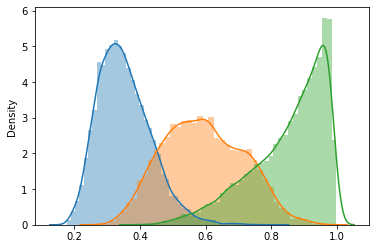

In [17]:
sns.distplot(mxfc.transform(X, alpha = .25).max(1).data)
sns.distplot(mxfc.transform(X, alpha = .5).max(1).data)
sns.distplot(mxfc.transform(X, alpha = 1).max(1).data)

c:\users\user ambev\desktop\mypackages\heartwood\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(5.661074660164821, 8.746979463337267)

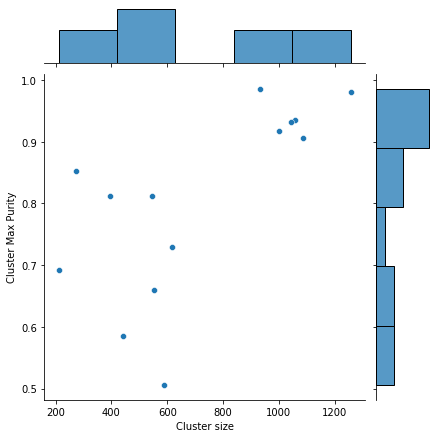

In [73]:
entropies = []
sizes = []
proportion_class = []
for c in np.unique(clusters):
    msk = clusters == c
    entropies.append(entropy(y[msk]))
    sizes.append(msk.sum())
    proportion_class.append(pd.Series(y[msk]).value_counts(1).max())

#jnt = sns.jointplot(sizes, entropies)
jnt = sns.jointplot(sizes, proportion_class)
jnt.ax_joint.set_xlabel('Cluster size')
jnt.ax_joint.set_ylabel('Cluster Max Purity')
np.array(entropies).mean(),entropy(y)

In [74]:
bpt = ForestBipartiteGraphTransformer(
    RandomForestClassifier(400, min_samples_leaf = 1),
    embedding_method='kmeans',
    n_clusters = 30,
).fit(X,y)


embeddings = bpt.transform(X).A
clusters = np.argmax(embeddings, 1)

#sns.scatterplot(X[:,0], X[:,1], hue = clusters, palette = 'tab20')
#sns.scatterplot(X[:,1], X[:,2], hue = embeddings.max(1) <.5)

np.unique(clusters, return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64),
 array([949, 793, 741, 712, 571, 568, 472, 429, 360, 349, 319, 307, 308,
        297, 242, 256, 233, 229, 224, 211, 182, 185, 168, 155, 151, 142,
        124, 127, 112,  84], dtype=int64))

c:\users\user ambev\desktop\mypackages\heartwood\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(4.879106388175367, 8.746979463337267)

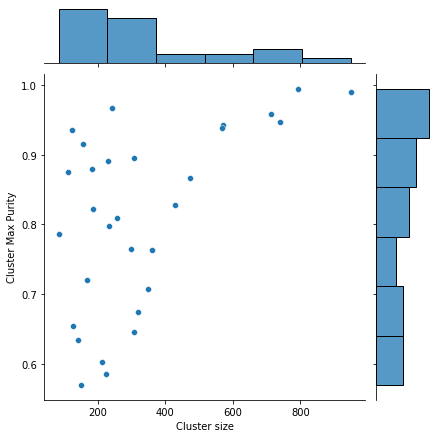

In [75]:
entropies = []
sizes = []
proportion_class = []
for c in np.unique(clusters):
    msk = clusters == c
    entropies.append(entropy(y[msk]))
    sizes.append(msk.sum())
    proportion_class.append(pd.Series(y[msk]).value_counts(1).max())

#jnt = sns.jointplot(sizes, entropies)
jnt = sns.jointplot(sizes, proportion_class)
jnt.ax_joint.set_xlabel('Cluster size')
jnt.ax_joint.set_ylabel('Cluster Max Purity')
np.array(entropies).mean(),entropy(y)

In [76]:
df['cluster'] = clusters
df['max_proba'] = embeddings.max(1)
px.scatter_3d(df, 'X0', 'X1', 'X2', color = 'y', symbol = 'cluster', size = 'max_proba')

(6.04897401256034, 8.74800360330211)

In [403]:
(embeddings == 0).mean()

0.48061

# Estimator Kernels

In [352]:
#export

class EstimatorKernel(BaseEstimator, TransformerMixin):    
    '''
    creates a kernel with some specified estimator.
    projection method will be performed according to projection_method.
    projection method can be a string refering to estimators method used to project,
    or a callable, that receives the estimator and X (vector to be projected) as the inputs.
    should return the projections of X according to estimator.
    norm will normalize vectors in matrices prior to applying dot products.
    '''
    def __init__(
        self,
        estimator:BaseEstimator,
        projection_method:Union[str,callable],
        nearest_neighbors_estimator,
        fit_neighbors_index:bool = True,
        n_neighbors:int = 30
    ):
        '''
        creates a kernel with some specified estimator.
        projection method will be performed according to projection_method.
        projection method can be a string refering to estimators method used to project,
        or a callable, that receives the estimator and X (vector to be projected) as the inputs.
        should return the projections of X according to estimator.
        norm will normalize vectors in matrices prior to applying dot products.
        '''
        self.estimator = estimator
        self.projection_method = projection_method
        self.nearest_neighbors_estimator = nearest_neighbors_estimator
        self.n_neighbors = n_neighbors
        self.fit_neighbors_index = fit_neighbors_index
        
    
    def __getattr__(self, attr):
        '''
        Allows accessing self.estimator attributes if not found in first object level
        '''
        return getattr(self.estimator, attr)
    
    def transform(self, X):
        '''
        projects X into new space, according to projection_method
        '''        
                        
        if callable(self.projection_method):
            return self.projection_method(self.estimator, X)
        else:
            return getattr(self.estimator, self.projection_method)(X)
    
    def fit(self, X, y = None, save_values = None, **kwargs):
        '''
        X is the feature space,
        y is used only for supervised Kernels
        save_values are values associated with each "Embeding". During transform,
        the values of saved_values are retrieved according to indexes returned by Nearest Neighbor query        
        '''
        if not save_values is None:
            if not len(save_values) == len(X):
                raise IndexError(f'X and save_values must have the same shape along the first dimension. Got {X.shape} and {save_values.shape}')
        
        self.estimator.fit(X, y, **kwargs)
        
        if self.fit_neighbors_index:
            #make space transformation
            train_projection_space_ = self.transform(X) #saves projection space of X in train

            if save_values is None:            
                save_values = np.empty((X.shape[0], 0)) #empty array        

            #fit index
            self.nearest_neighbors_estimator.fit(train_projection_space_)

            #save states
            #self.train_projection_space_ = train_projection_space_ #is it really necessary to save this? possibly yieds memory overhead
            self.train_projection_values_ = save_values
        
        return self
                
            
    def kneighbors(self, X = None, n_neighbors = None, return_distance = True):
        '''
        runs nearest neighbor search in the transformed space index
        '''        
                    
        if not self.fit_neighbors_index:
            raise AttributeError('This method is only available when fit_neighbors_index is set to True in the constructor')
        
        if n_neighbors is None:
            n_neighbors = self.n_neighbors
            
        #make space transformation
        X = self.transform(X)
        #query in index
        result = self.nearest_neighbors_estimator.kneighbors(X, n_neighbors = n_neighbors, return_distance = return_distance)
                
        return result #dist, idxs
    
    def kneighbors_graph(self, X = None, n_neighbors = None, mode = 'similarity'):
        
        if not self.fit_neighbors_index:
            raise AttributeError('This method is only available when fit_neighbors_index is set to True in the constructor')
        
        if n_neighbors is None:
            n_neighbors = self.n_neighbors
            
        #make space transformation
        if not X is None:
            X = self.transform(X)
        #query in index
        graph = self.nearest_neighbors_estimator.kneighbors_graph(X, n_neighbors = n_neighbors, mode = mode)
        return graph
        
    def query(self, X = None, n_neighbors = None):
        '''
        same as kneighbors, but instead of returning indexes, returns values in self.train_projection_values_
        '''
        if not self.fit_neighbors_index:
            raise AttributeError('This method is only available when fit_neighbors_index is set to True in the constructor')
            
        dist, idxs = self.kneighbors(X, n_neighbors, return_distance = True)
        
        if hasattr(self.train_projection_values_, 'iloc'):
            values = [self.train_projection_values_.iloc[idx] for idx in idxs]        
        
        else:
            values = [self.train_projection_values_[idx] for idx in idxs]
        
        return values, dist
    
    def update_space(self, X, save_values = None):
        '''
        updates self.train_projection_space_ and self.train_projection_values_ with new data.
        new values are found running self.transform on X
        '''
        if not self.fit_neighbors_index:
            raise AttributeError('This method is only available when fit_neighbors_index is set to True in the constructor')
        
        X = self.transform(X)
        
        self.train_projection_space_ = vstack([self.train_projection_space_, X])
        
        if save_values is None:            
            save_values = np.empty((X.shape[0], self.train_projection_values_.shape[-1])) #empty array
            
        
        #refit knn index
        self.nearest_neighbors_estimator.fit(self.train_projection_space_)
        
        self.train_projection_values_ = vstack([self.train_projection_values_, save_values])        
        return self

## JaccardForestKernel

In [353]:
#export
class JaccardForestKernel(EstimatorKernel):
    '''
    A Space tranformation performed based on Forest transformations.
    Can be supervised or not (CARTs, RandomTreeEmbeddings, Boosted trees...)
    
    the embedding_space is sparse and can be defined as the `decision_path` space or `terminal_nodes`
    space.
    '''             
    
    def __init__(
        self,
        estimator:BaseEstimator,
        n_neighbors:int = 30,
        fit_neighbors_index:bool = True,
        index_time_params:dict={'M': 30, 'indexThreadQty': 4, 'efConstruction': 100, 'post': 0},
        query_time_params:dict={'efSearch': 100},
        verbose:bool = False
    ):
        
        #save init params for sklearn consistency
        self.n_neighbors = n_neighbors
        self.index_time_params=index_time_params
        self.query_time_params=query_time_params
        self.verbose=verbose
        self.fit_neighbors_index=fit_neighbors_index
        
        #instantiate jacard distance nearest neighbor index
        nn_obj = FastJaccardNN(
            n_neighbors = n_neighbors,
            index_time_params=index_time_params,
            query_time_params=query_time_params,
            verbose=verbose,
        )
                        
        super().__init__(
            estimator = estimator,
            projection_method=None,
            nearest_neighbors_estimator=nn_obj,
            fit_neighbors_index=fit_neighbors_index,
            n_neighbors=n_neighbors            
        )        
        
        return
    
    def transform(self, X):
        
        X = self.estimator.apply(X)
        #handle boosting case
        if len(X.shape) > 2:
            X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
            
        if hasattr(self, 'one_hot_node_embeddings_encoder_'):            
            X = self.one_hot_node_embeddings_encoder_.transform(X)

        else:            
            self.one_hot_node_embeddings_encoder_ = OneHotEncoder().fit(X)
            X = self.one_hot_node_embeddings_encoder_.transform(X)
                            
        return X 

In [365]:
(embeddings < .1).mean()

0.953235

In [357]:
#dgp

X,y = make_bimodal_assymetric_regression(10_000)

In [358]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, RandomForestRegressor

fkernel = JaccardForestKernel(RandomForestRegressor())
fkernel.fit(X, y, save_values = y)

JaccardForestKernel(estimator=RandomForestRegressor())

In [ ]:
fkernel.query(X[:2])

## CategoricalLinearKernel

In [349]:
#export
class CategoricalLinearKernel(EstimatorKernel):    
    '''
    Linear model kernel recommended for high cardinality one hot encoded categorical variables.
    kernel space is defined by liner model coefficients indexed by the nonzero elements
    of X
    
    If encode is set to true, a customized onehotencoder will encode the categorical input.
    
    This kernel will only work if the output of the one hot encoded vectors  have always the same number
    of nonzero elements (equal to the number of categorical features). Thus, its recomended to use the default
    encoder, because it asserts this condition is met during one hot encoding
    '''
    
    def __init__(
        self,
        estimator,
        n_neighbors=30,
        fit_neighbors_index = True,
        encode = False,
        n_components = None,
        index_time_params={'M': 30, 'indexThreadQty': 8, 'efConstruction': 100, 'post': 0},
        query_time_params={'efSearch': 100},
        verbose=False,
        **pcakwargs
    ):
        
        self.encode = encode
        self.n_components = n_components
        self.pcakwargs = pcakwargs
        self.estimator = estimator
                
        #save init params for sklearn consistency
        self.n_neighbors = n_neighbors
        self.index_time_params=index_time_params
        self.query_time_params=query_time_params
        self.verbose=verbose
        self.fit_neighbors_index=fit_neighbors_index
        
        #instantiate jacard distance nearest neighbor index
        nn_obj = FastL2NN(
            n_neighbors = n_neighbors,
            index_time_params=index_time_params,
            query_time_params=query_time_params,
            verbose=verbose,
        )
                        
        super().__init__(
            estimator = estimator,
            projection_method=None,
            nearest_neighbors_estimator=nn_obj,
            fit_neighbors_index=fit_neighbors_index,
            n_neighbors=n_neighbors            
        )        
                
        return    
    
    def fit(self, X, y = None, save_values = None, **kwargs):
        
        if self.encode:            
            if not self.n_components is None:
                self.estimator = make_pipeline(RobustEncoder(), self.estiamtor, PCA(self.n_components, **self.pcakwargs))
            else:
                self.estimator = make_pipeline(RobustEncoder(), self.estimator)
        else:
            if not self.n_components is None:
                self.estimator = make_pipeline(self.estiamtor, PCA(self.n_components, **self.pcakwargs))
            else:
                pass
                                
        return super().fit(X, y, save_values, **kwargs)
    
    def transform(self, X):
        '''
        multiplies sparse vector to its coef_ s from linear model.
        if multiclass classification, the number of final features will be
        n*original_n_features_before_one_hot_encoding
        '''
        
        if self.encode:
            coefs = self.estimator[-1].coef_
            X = self.estimator[0].transform(X)
        else:            
            coefs = self.estimator.coef_
        
        #create attr if it does now exist yet:
        #this line is supposed to run only during fit call
        if not hasattr(self,'dim_embeddings_'):
            self.dim_embeddings_ = len(X[0].data)
                
        if len(coefs.shape) == 1:
            coefs = coefs.reshape(1,-1)
        
        embeddings = []
        for dim in range(coefs.shape[0]):
            #assumes all rows have the same ammount of nonzero elements
            dim_embeddings = coefs[dim, X.nonzero()[1]].reshape(X.shape[0], self.dim_embeddings_)
            embeddings.append(dim_embeddings)                    
                
        return hstack(embeddings)
    

In [24]:
from sklearn.linear_model import SGDClassifier, SGDRegressor

X_cat = np.random.randint(0,10, size = (10_000, 100)).astype(str)
y_reg = np.random.randn(10_000,1)

In [25]:
cat_kernel = CategoricalLinearKernel(SGDRegressor(), encode = True)
cat_kernel.fit(X_cat, y_reg, save_values = y_reg)

c:\users\user ambev\desktop\mypackages\heartwood\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CategoricalLinearKernel(encode=True,
                        estimator=Pipeline(steps=[('robustencoder',
                                                   RobustEncoder()),
                                                  ('sgdregressor',
                                                   SGDRegressor())]))

In [26]:
cat_kernel.query(X_cat[:2])

([array([[ 0.75131392],
         [ 0.14790968],
         [-0.72471629],
         [-1.4413358 ],
         [ 0.03990467],
         [ 0.10910946],
         [ 1.5351463 ],
         [ 0.54819518],
         [ 0.368883  ],
         [-0.49814587],
         [ 0.55611049],
         [-1.93758336],
         [ 0.82971074],
         [-0.11549446],
         [-0.39815426],
         [-0.0313381 ],
         [ 0.3689665 ],
         [-0.04878705],
         [ 0.08720136],
         [ 0.8904295 ],
         [-0.58962797],
         [-1.08723441],
         [ 3.12410873],
         [-0.06718426],
         [ 1.03804078],
         [ 0.70854673],
         [-0.43204652],
         [ 0.54480574],
         [ 0.03619711],
         [ 0.4013929 ]]),
  array([[-0.51501537],
         [ 0.57677978],
         [ 0.8394021 ],
         [-0.77986324],
         [ 0.50513874],
         [-0.67342598],
         [ 0.96447019],
         [ 0.4542087 ],
         [ 0.65358693],
         [-1.91023683],
         [-0.05376845],
         [-0.1

## LinearBottleneckKernel

In [27]:
#export
class ClassificationLinearBottleneck(MLPClassifier):
    '''
    Linear boottleneck of a classification task, usefull for dimensionality reduction
    or densification of sparse representations.
    '''
    def __init__(
        self,
        n_components = 2,        
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=200,
        shuffle=True,
        random_state=None,
        tol=0.0001,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=10,
        max_fun=15000,
    ):
        
        #set attributes, some will be overriden in super().__init__ call        
        self.solver = solver
        self.alpha = alpha
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.power_t = power_t
        self.max_iter = max_iter
        self.shuffle = shuffle
        self.random_state = random_state
        self.tol = tol
        self.verbose = verbose
        self.warm_start = warm_start
        self.momentum = momentum
        self.nesterovs_momentum = nesterovs_momentum
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.n_iter_no_change = n_iter_no_change
        self.max_fun = max_fun
                        
        super().__init__(hidden_layer_sizes = (n_components,), activation = 'identity', **self.__dict__)
        self.n_components = n_components
        return
    
    def transform(self, X, **kwargs):
        '''
        projects inputs to have size (n_samples, n_components)
        '''        
        return _get_sklearn_mlp_activations(self, X)
        

class RegressionLinearBottleneck(MLPRegressor):
    '''
    Linear boottleneck of a classification task, usefull for dimensionality reduction
    or densification of sparse representations.
    '''
    def __init__(
        self,
        n_components = 2,        
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=200,
        shuffle=True,
        random_state=None,
        tol=0.0001,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=10,
        max_fun=15000,
    ):
        
        #set attributes, some will be overriden in super().__init__ call        
        self.solver = solver
        self.alpha = alpha
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.power_t = power_t
        self.max_iter = max_iter
        self.shuffle = shuffle
        self.random_state = random_state
        self.tol = tol
        self.verbose = verbose
        self.warm_start = warm_start
        self.momentum = momentum
        self.nesterovs_momentum = nesterovs_momentum
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.n_iter_no_change = n_iter_no_change
        self.max_fun = max_fun
                        
        super().__init__(hidden_layer_sizes = (n_components,), activation = 'identity', **self.__dict__)
        self.n_components = n_components
        return
    
    def transform(self, X, **kwargs):
        '''
        projects inputs to have size (n_samples, n_components)
        '''        
        return _get_sklearn_mlp_activations(self, X)

In [28]:
#export
def _get_sklearn_mlp_activations(self, X, output_layer = -2):
    hidden_layer_sizes = self.hidden_layer_sizes
    if not hasattr(hidden_layer_sizes, "__iter__"):
        hidden_layer_sizes = [hidden_layer_sizes]
    hidden_layer_sizes = list(hidden_layer_sizes)
    layer_units = [X.shape[1]] + hidden_layer_sizes + \
        [self.n_outputs_]
    activations = [X]
    for i in range(self.n_layers_ - 1):
        activations.append(np.empty((X.shape[0],
                                     layer_units[i + 1])))
    self._forward_pass(activations)
    return activations[output_layer]

## MLPKernel

In [29]:
#export
class MLPKernel(EstimatorKernel):
    
    '''
    returns the output of last hidden layer (before softmax/linear layer)
    as space projection.
    
    Recomended for dimensionality reduction and Context specific bag of words task
    '''    
    def __init__(self, estimator, output_layer = -2, norm='l2'):
        
        self.projection_method = partial(_get_sklearn_mlp_activations, output_layer = output_layer)
        self.estimator = estimator
        self.output_layer = output_layer
        self.norm = norm
        return
    
    

In [30]:
#export
class BOWKernel(MLPKernel):
    '''
    `MLPKernel` Alias, intended for Bag Of Words application.
    Generates supervised embeddings (context specific embeddings)
    '''
    pass

## DiscretizedTargetKernel

In [ ]:
KBinsDiscretizer()
class DiscretizedTargetTransformer(BaseEstimator):
    
    def __init__(
        self,
        estimator,
        n_bins=5,
        encode='ordinal',
        strategy='kmeans',
        dtype=None,   
    ):
        '''
        Fits a supervised 
        '''
    

In [344]:
#export

class DiscretizedTargetKernel(EstimatorKernel):
    
    def __init__(
        self,
        estimator,
        n_bins=10,
        encode='ordinal',
        strategy='kmeans',        
        n_neighbors=30,
        fit_neighbors_index = True,
        index_time_params={'indexThreadQty': 8, 'efConstruction': 100},
        query_time_params={'efSearch': 100},
        verbose=False,            
    ):
        
                
        #save init params for sklearn consistency
        self.n_neighbors = n_neighbors
        self.index_time_params=index_time_params
        self.query_time_params=query_time_params
        self.verbose=verbose
        self.fit_neighbors_index=fit_neighbors_index
        self.n_bins=n_bins
        self.encode=encode
        self.strategy=strategy
        
        #instantiate KL Divergence nearest neighbor index
        nn_obj = FastKLDivNN(
            n_neighbors = n_neighbors,
            index_time_params=index_time_params,
            query_time_params=query_time_params,
            verbose=verbose,
        )
                        
        super().__init__(
            estimator = estimator,
            projection_method='predict_proba',
            nearest_neighbors_estimator=nn_obj,
            fit_neighbors_index=fit_neighbors_index,
            n_neighbors=n_neighbors            
        )        
        
        return
    
    def fit(self, X, y = None, save_values = None, **kwargs):
        
        discretizer = KBinsDiscretizer(
            n_bins = self.n_bins,
            encode = self.encode,
            strategy = self.strategy,            
            
        )
        
        y = discretizer.fit_transform(y)
        
        self.discretizer = discretizer                                
        return super().fit(X, y, save_values, **kwargs)
    
    def transform(self, X):
        
        X = self.estimator.predict_proba(X)
        #handle multiclass (multi dimensional joint dist)
        if isinstance(X, list):
            X = hstack(X)
        return X
    
    

NameError: name 'EstimatorKernel' is not defined

In [343]:
from sklearn.ensemble import RandomForestClassifier
X, y = make_bimodal_assymetric_regression(10_000)

discrete_kernel = DiscretizedTargetKernel(RandomForestClassifier(), n_bins = 30, n_neighbors = 100,  strategy = 'kmeans')

discrete_kernel.fit(X, y, save_values = y)

NameError: name 'DiscretizedTargetKernel' is not defined

c:\users\user ambev\desktop\mypackages\heartwood\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


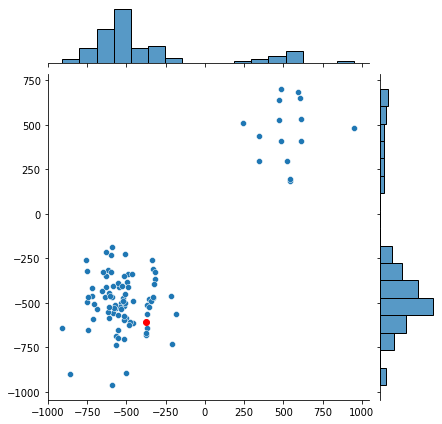

In [35]:
idx = np.random.choice(len(X))

plot = sns.jointplot(*discrete_kernel.query(X[idx:idx+1])[0][0].T)
plot.ax_joint.scatter(*y[idx], color = 'r')

# Export

In [6]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted cluster.ipynb.
Converted index.ipynb.
Converted kernel.ipynb.
Converted utils.ipynb.
